In [1]:
import jax
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from datasets import load_dataset

from wheeljax.model import TransformerLM
from wheeljax.train import CollatorForCausalLM, LMTrainer

/home/orquestra/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# list jax devices
print(jax.devices())

# catches XLA ptxas<11.8 error on GPU
jax.numpy.zeros((2, 2))

[cuda(id=0)]


2023-12-20 23:01:32.975132: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([[0., 0.],
       [0., 0.]], dtype=float32)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [4]:
tokenizer.pad_token = tokenizer.eos_token

In [5]:
# load the dataset
d = load_dataset("huanggab/reddit_haiku", data_files={'test':'merged_with_keywords.csv'})  # use data_files or it will result in error

# we will use test to compute the test perplexity
train_test_ratio = 0.8
d['test'] = d['test'].train_test_split(test_size=1-train_test_ratio)

# Now you have the train and test datasets
train_dataset = d['test']['train']
test_dataset = d['test']['test']


In [6]:
train_dataset, test_dataset

(Dataset({
     features: ['Unnamed: 0', 'id', 'processed_title', 'ups', 'keywords'],
     num_rows: 12224
 }),
 Dataset({
     features: ['Unnamed: 0', 'id', 'processed_title', 'ups', 'keywords'],
     num_rows: 3057
 }))

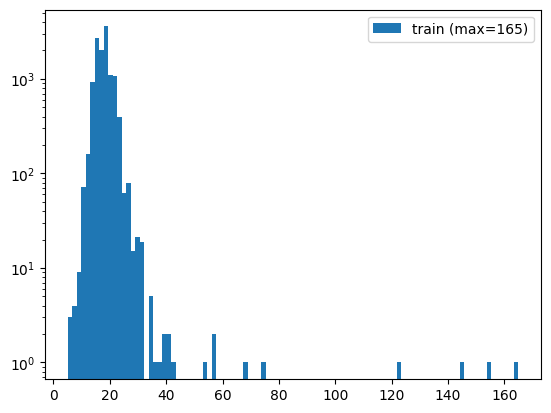

In [7]:
# plot the distribution of the lengths of the sequences
lengths = []

for row in train_dataset:
    lengths.append(len(tokenizer(row['processed_title'])['input_ids']))

plt.hist(lengths, bins=100, log=True, label=f"train (max={max(lengths)})")
plt.legend()
plt.show()

In [8]:
# get a max length that covers the vast majority of the data
quantile = 0.999
max_length = int(np.round(np.quantile(lengths, 0.999)))
print(f"{quantile * 100: .2f}% of lengths are <= {max_length}")

 99.90% of lengths are <= 40


In [9]:
train_dataset = train_dataset.map(
    lambda x: tokenizer(
        x['processed_title'], 
        padding='max_length',
        truncation=True,
        max_length=max_length
    ), 
    batched=True,
    remove_columns=['Unnamed: 0', 'processed_title', 'keywords', "ups", "id", "processed_title"],
)

# test_dataset = test_dataset.map(
#     lambda x: tokenizer(x['processed_title'], padding='max_length', truncation=True), 
#     batched=True,
#     remove_columns=['Unnamed: 0', 'processed_title', 'keywords', "ups", "id", "processed_title"]
# )

Map: 100%|██████████| 12224/12224 [00:00<00:00, 16862.66 examples/s]


In [10]:
list(train_dataset[0].keys())
print(len(train_dataset[0]['input_ids']))

40


In [11]:
random_seed = 42
batch_size = 32

rng = torch.Generator()
rng.manual_seed(random_seed)

collator = CollatorForCausalLM(tokenizer)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    generator=rng,
    collate_fn=collator
)

In [12]:
for batch in train_loader:
    break

print(list(batch.keys()))

['inputs', 'labels', 'lookahead_mask', 'padding_mask']


In [13]:
print(tokenizer.vocab_size)

50257


In [14]:
model = TransformerLM(
    dim_feedforward=32,
    model_dim=64,
    num_heads=4,
    num_encoder_layers=4,
    vocab_size=tokenizer.vocab_size
)

In [15]:
n_epochs = 2

trainer = LMTrainer(
    model, 
    example_batch=batch, 
    max_iters=len(train_loader) * n_epochs,
    report_to="wandb"
)

/home/orquestra/jax-transformer/wheeljax/model/transformer.py:58: UserWarning: Transformer recieved unknown keyword argument labels - ignoring
  warn(f"Transformer recieved unknown keyword argument {key} - ignoring")


In [16]:
trainer.train(n_epochs, train_loader)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: djvaroli. Use `wandb login --relogin` to force relogin


Epoch 2 / 2: 100%|██████████| 2/2 [01:10<00:00, 35.35s/it, loss=3.05, perplexity=21.3]   


In [18]:
input_text = "<|endoftext|> an orange and an apple walk into a"
input_tokens = tokenizer.encode(input_text, return_tensors="jax")

tokens = model.generate(
    trainer.state.params,
    input_tokens=input_tokens,
    rng_key=jax.random.PRNGKey(42),
)

Generating: 100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


In [19]:
tokenizer.batch_decode(tokens.tolist(), skip_special_tokens=True)

[' an orange and an apple walk into aAt, lights/ beautiful" a toplease.']